<a href="https://colab.research.google.com/github/Hubz-source/hello-world/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, add
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.test import gpu_device_name
from google.colab import drive
import matplotlib.pyplot as plt

# Connect to google drive:
drive.mount('/content/drive')
os.chdir('./drive/MyDrive/ML_Mech/src')
# Own files:
from build_model_andi import build_model_andi
from build_model_u import build_model_u

# TODO Normalize image data (Batch normalization)



# Settings
#==============
# General
BATCH_SIZE = 16   # Default is 48
ImDatGen_SETTINGS= dict(width_shift_range = 0.1, 
                        height_shift_range = 0.1,
                        rotation_range = 15, 
                        zoom_range = 0.3)
SEED = 420    #Seed for ImageDataGenerator, makes shure x and y are transformed consistently

#Model building
activation='selu'
padding='same'







Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def load_train_data():
    ''' Load training data. Non dynamic data structure. Directories should be organized as:
    .    
    │   
    ├───data
    │   ├───crop
    │   │   ├───testing
    │   │   │   
    │   │   └───training
    │   │       └───segmentation
    │   └───raw
    └───src
    Args:
        None

    Returns:
        X   (list): List of image data in RGB
        y   (list): list of gt bitmasks, grey scale
    '''
    print(os.getcwd())
    training_path_x = os.path.join('..', 'data', 'crop', 'training')
    training_path_y = os.path.join('..', 'data', 'crop', 'training', 'segmentation')

    X = []
    y = []
    
    # Iterate over gt, as it contains no dir itself
    for filename in os.listdir(str(training_path_y)):
      img = plt.imread(os.path.join(training_path_x, filename))
      gt = plt.imread(os.path.join(training_path_y, filename))

      X.append(img)
      #y.append(gt[:,:,:3])
      y.append(gt[:,:,0])

    X = np.array(X)
    y = np.array(y)
    
    print('Shape of input: ', X.shape)
    print('Shape of gt: ', X.shape)
    return X, y


In [3]:
def data_generator(x, y, ImDatGen_SETTINGS, batchsize=48, seed=42):
    ''' Perform online data augmentation to x and y images. 

    Args:
        X   (list): List of image data in RGB
        y   (list): list of gt bitmasks, grey scale
        batchsize (int): self explanatory
        ImDatGen_SETTINGS (dict): Dict containing ImageDateGenerator Arguments, handed as **kwargs
    Returns:
        training_iterator (tuple): Iterator for training process, 

    '''

    x_gen = ImageDataGenerator(**ImDatGen_SETTINGS)
    y_gen = ImageDataGenerator(**ImDatGen_SETTINGS)

    # TODO check if second argument of flow method (labels) can be used like this
    #print(x.shape)
    #x_iterator = x_gen.flow(x, x, batch_size=batchsize, seed=seed)
    #y_iterator = y_gen.flow(y, y, batch_size=batchsize, seed=seed)
    
    x_iterator = x_gen.flow(x, batch_size=batchsize, seed=seed)
    y_iterator = y_gen.flow(y, batch_size=batchsize, seed=seed)

    #print(next(zip(x_iterator, y_iterator)))

    return  zip(x_iterator, y_iterator)


In [68]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import UpSampling2D


def small_unet(img_size, num_classes, activation='relu', padding='same'):
  clear_session()
  #TODO Play around with filter size, layers etc. Ideally add padding layers (for example inspired by ResNet32 for example)
  #TODO add dropout layers
  # See if this works, or if (n, n, 3, ) is necessary (explicit blank)
  inputs = Input(shape = img_size + (3,))
  ### Encoder Part of the Network
  down_layers = []
  x = Conv2D(32, 3, padding=padding)(inputs)
  for fm in [32,64,128]:
    if fm is not 32:
      x = Conv2D(fm, 3, padding=padding)(x)
    x = Conv2D(fm, 3, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    down_layers.append(x)
    if fm == 128:
      x = Dropout(0.05)(x)
    x = MaxPooling2D(3, strides=2, padding=padding)(x)
  
  #Laten space part of the network
  x = Conv2D(256, 3, padding=padding)(x)
  x = Conv2D(256, 3, padding=padding)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = Dropout(0.05)(x)
  down16 = x

  #reverse drop out list for easier access:
  print(down_layers)
  down_layers = list(reversed(down_layers))
  print(down_layers)
  #Decoder:
  
  #x = Activation(activation)(x)
  #x = Conv2DTranspose(256, 3, padding=padding)(x)
  #x = BatchNormalization()(x)

  #x = Activation(activation)(x)
  #x = Conv2DTranspose(256, 3, padding=padding)(x)
  #x = BatchNormalization()(x)

  #x = UpSampling2D(2)(x)
  #in unet its concatenate. Maybe try this
  #x = Concatenate()([x,down16])
  i = 0
  for fm in [128,64,32]:
    print(i)
    x = UpSampling2D(2)(x)
    x = Conv2DTranspose(fm, 3, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Concatenate()([x,down_layers[i]])
    i += 1
  # Output
  x = Conv2D(32, 3, padding=padding)(x)
  outputs = Conv2D(num_classes, 3, activation="softmax", padding=padding)(x)
  model = Model(inputs, outputs)
  return model


In [23]:
from tensorflow.keras.layers import Concatenate





def build_model_u_dump(img_size, num_classes, activation='relu', padding='same'):
  ''' simple U-Net 

      Args:
        img_shape     (tuple of ints): Shape of input image, used to define input layer
        num_classes   (int): number of predicted classes, later detected as seperate output channels
        activation    (str, optional): String which defines activation function in activation layers. Default is 'relu'
        padding       (str, optional): String which defines padding layers. Default is 'same'

      Returns:
        model         (obj): Keras model object (https://www.tensorflow.org/api_docs/python/tf/keras/Model) 
  '''
  #Clear old keras sessions
  clear_session()
  #TODO Play around with filter size, layers etc. Ideally add padding layers (for example inspired by ResNet32 for example)
  #TODO add dropout layers
  # See if this works, or if (n, n, 3, ) is necessary (explicit blank)
  inputs = Input(shape = img_size + (3,))
  ### Encoder Part of the Network
  x = Conv2D(32, 3, padding=padding)(inputs)
  x = Conv2D(32, 3, padding=padding)(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  down128 = x
  x = MaxPooling2D(3, strides=2, padding=padding)(x) 


  # first block:
  # =========================
  x = Activation(activation)(x)
  x = SeparableConv2D(64, 3, padding=padding)(x)     #First spatial conv on each channel separately, then pointwise through channels (No real idea on effect, but should take in effects of gradients through channels/ combined masks)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = SeparableConv2D(64, 3, padding=padding)(x)
  x = BatchNormalization()(x)
  #  jump to next depth
  down64 = x
  x = MaxPooling2D(3, strides=2, padding=padding)(x) 
  # Project residual (Not quite shure what to do with that yet)
  #TODO, CORRECT TO CORRECT CONNECTION
  #residual = Conv2D(64, 1, strides=2, padding=padding)(prev_block)
  #x = add([x, residual])  
  #32_down = x
  #prev_block = x 
  # ==========================


  # second block:
  # =========================
  x = Activation(activation)(x)
  x = SeparableConv2D(128, 3, padding=padding)(x)     #First spatial conv on each channel separately, then pointwise through channels (No real idea on effect, but should take in effects of gradients through channels/ combined masks)
  x = BatchNormalization()(x)
  # second block
  x = Activation(activation)(x)
  x = SeparableConv2D(128, 3, padding=padding)(x)
  x = BatchNormalization()(x)
  #  jump to next depth
  down32 = x
  x = MaxPooling2D(3, strides=2, padding=padding)(x)

  # Project residual (Not quite shure what to do with that yet)
  #TODO, CORRECT TO CORRECT CONNECTION
  #residual = Conv2D(128, 1, strides=2, padding=padding)(prev_block)
  #x = add([x, residual])  
  #16_down = x
  #prev_block = x  
  # ==========================

  # third block:
  # =========================
  x = Activation(activation)(x)
  x = SeparableConv2D(256, 3, padding=padding)(x)     #First spatial conv on each channel separately, then pointwise through channels (No real idea on effect, but should take in effects of gradients through channels/ combined masks)
  x = BatchNormalization()(x)
  # second block
  x = Activation(activation)(x)
  x = SeparableConv2D(256, 3, padding=padding)(x)
  x = BatchNormalization()(x)
  #  jump to next depth
  down16 = x
  x = MaxPooling2D(3, strides=2, padding=padding)(x)

  # Project residual (Not quite shure what to do with that yet)
  #TODO, CORRECT TO CORRECT CONNECTION
  #residual = Conv2D(256, 1, strides=2, padding=padding)(prev_block)
  #x = add([x, residual])  
  #8_down = x
  #prev_block = x



  # Decoder part:
  # First block
  # =======================
  x = Activation(activation)(x)
  x = Conv2DTranspose(256, 3, padding=padding)(x)
  x = BatchNormalization()(x)

  x = Activation(activation)(x)
  x = Conv2DTranspose(256, 3, padding=padding)(x)
  x = BatchNormalization()(x)

  x = UpSampling2D(2)(x)
  #in unet its concatenate. Maybe try this
  x = Concatenate()([x,down16])
  # Project residual
  #residual = UpSampling2D(2)(prev_block)
  #residual = Conv2D(256, 1, padding=padding)(residual)
  #x = add([x, 8_down])  # Add back residual
  #prev_block = x  # Set aside next residual
  # =======================

  # second block
  # =======================
  #x = Conv2D(128, 3, padding=padding)(x)
  x = Activation(activation)(x)
  x = Conv2DTranspose(128, 3, padding=padding)(x)
  x = BatchNormalization()(x)

  x = Activation(activation)(x)
  x = Conv2DTranspose(128, 3, padding=padding)(x)
  x = BatchNormalization()(x)

  x = UpSampling2D(2)(x)
  x = Concatenate()([x,down32])
  # Project residual
  #residual = UpSampling2D(2)(prev_block)
  #residual = Conv2D(128, 1, padding=padding)(residual)
  #x = add([x, 16_down])  # Add back residual
  #prev_block = x  # Set aside next residual

  # third block
  # =======================
  #x = Conv2D(64, 3, padding=padding)(x)
  x = Activation(activation)(x)
  x = Conv2DTranspose(64, 3, padding=padding)(x)
  x = BatchNormalization()(x)

  x = Activation(activation)(x)
  x = Conv2DTranspose(64, 3, padding=padding)(x)
  x = BatchNormalization()(x)

  x = UpSampling2D(2)(x)
  x = Concatenate()([x, down64])
  # Project residual
  #residual = UpSampling2D(2)(prev_block)
  #residual = Conv2D(64, 1, padding=padding)(residual)
  #x = add([x, 16_down])  # Add back residual
  #prev_block = x  # Set aside next residual
  
  # fourth block
  # =======================
  #x = Conv2D(32, 3, padding=padding)(x)
  x = Activation(activation)(x)
  x = Conv2DTranspose(32, 3, padding=padding)(x)
  x = BatchNormalization()(x)

  x = Activation(activation)(x)
  x = Conv2DTranspose(32, 3, padding=padding)(x)
  x = BatchNormalization()(x)

  x = UpSampling2D(2)(x)
  x = Concatenate()([x, down128])
  #x = Conv2D(32, 3, padding=padding)
  # Misses origiginal size convoluted image to add here
  # Project residual
  #residual = UpSampling2D(2)(prev_block)
  #residual = Conv2D(32, 1, padding=padding)(residual)
  #x = add([x, 16_down])  # Add back residual
  #prev_block = x  # Set aside next residual




  # Add a per-pixel classification layer
  outputs = Conv2D(num_classes, 3, activation="softmax", padding=padding)(x)
  
  #Group inputs and outputs + complete the keras object:
  model = Model(inputs, outputs)
  return model

In [5]:
x_train, y_train = load_train_data()



/content/drive/My Drive/ML_Mech/src
Shape of input:  (480, 128, 128, 3)
Shape of gt:  (480, 128, 128, 3)


In [6]:

print(y_train.shape)
y_train = np.reshape(y_train,(y_train.shape[0], y_train.shape[1],y_train.shape[2], -1))
print(y_train.shape)


(480, 128, 128)
(480, 128, 128, 1)


In [ ]:
# Plot some masks and images for overview, 
# TODO put in function/ as command line entry later



fig,axs = plt.subplots(2,4, figsize=(12,6))
axs = axs.flatten()
#Call iterator
train_iterator = data_generator(x_train, y_train, ImDatGen_SETTINGS, batchsize=BATCH_SIZE, seed=SEED)

#print(next(train_iterator))
img, mask = next(train_iterator)

#Plot in same logic as in assignment
for i in range(4):
    axs[2*i].imshow(img[i])  
    axs[2*i+1].imshow(np.reshape(mask[i],(128,128)))

for ax in axs:
    ax.axis("off")
plt.tight_layout()
print(np.reshape(mask[0],(128,128)))

In [ ]:
model = build_model_andi((128,128), 1, activation=activation, padding=padding)
model.summary()
plot_model(model, show_shapes=True, show_dtype=False,
    show_layer_names=True, expand_nested=False)

[<KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'activation')>, <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'activation_1')>, <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'activation_2')>]
[<KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'activation_2')>, <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'activation_1')>, <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'activation')>]
0
1
2
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 1

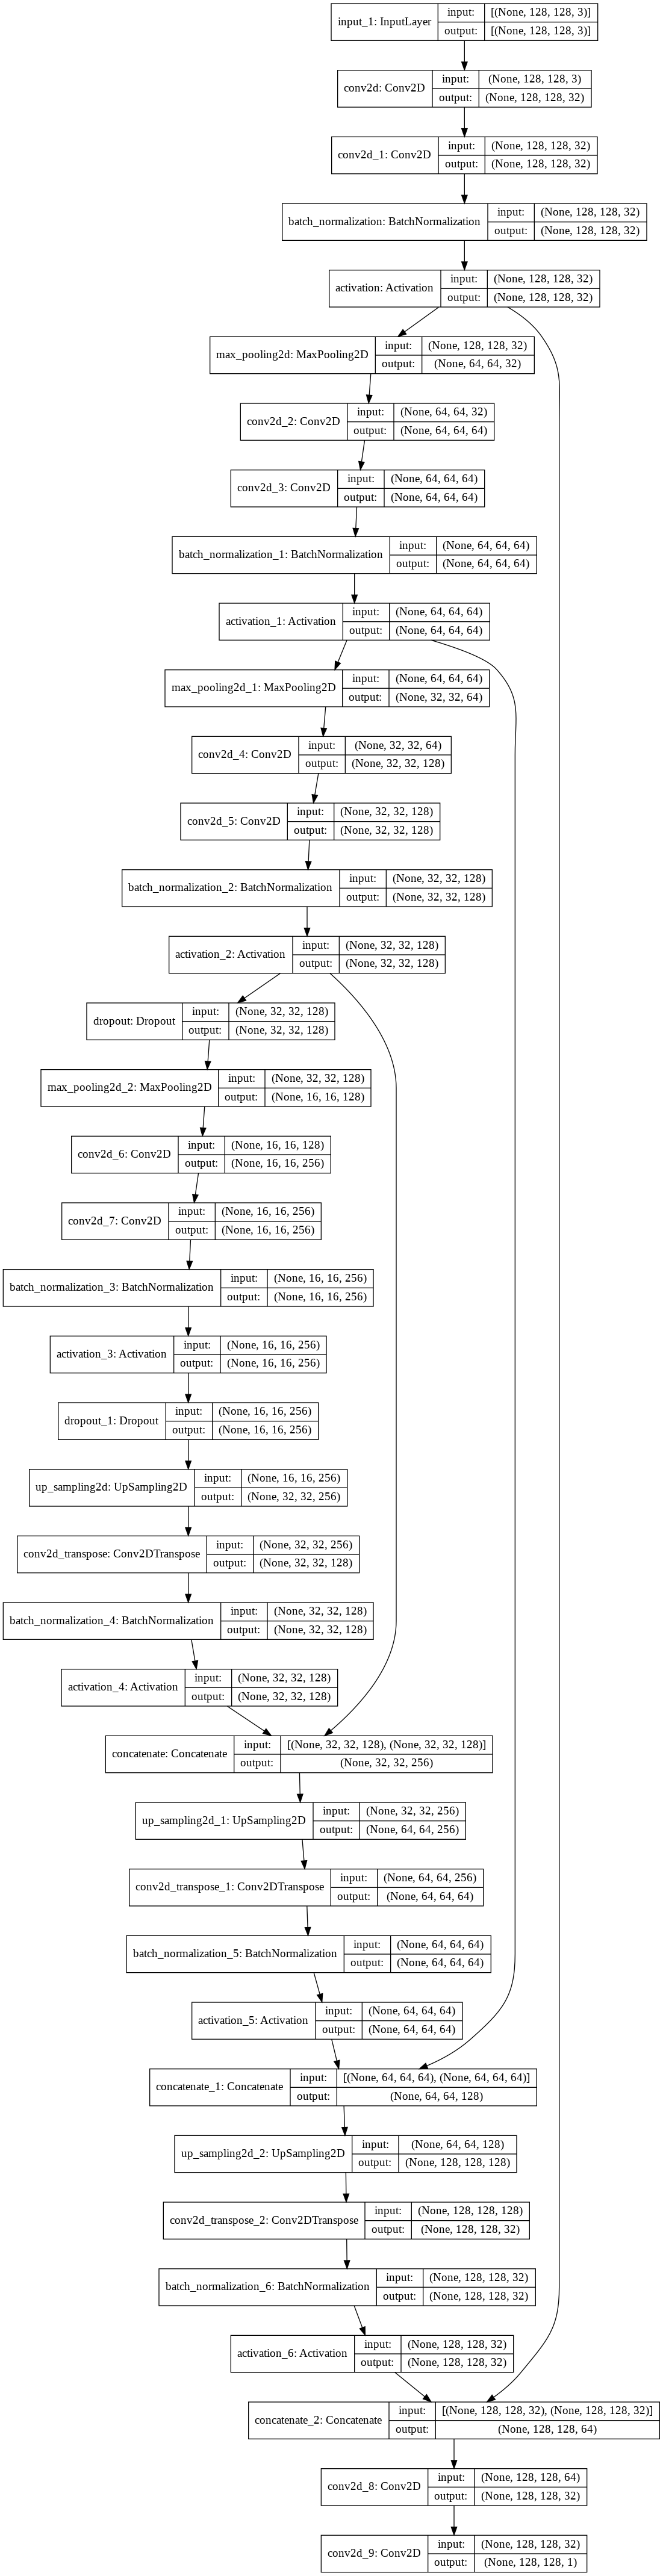

In [69]:
model = small_unet((128,128), 1, activation=activation, padding=padding)
model.summary()
plot_model(model, show_shapes=True, show_dtype=False,
    show_layer_names=True, expand_nested=False)

In [70]:
import tensorflow as tf

# TODO: Think about other losses and metrics
model.compile('adam', loss='bce', metrics=['accuracy'])
# Force usage of GPU: (code from colab documentation)
device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
with tf.device('/device:GPU:0'):
    history = model.fit(train_iterator, batch_size=16, steps_per_epoch=48, epochs=50,  verbose=1)


Found GPU at: /device:GPU:0
Epoch 1/50
48/48 [==============================] - 8s 109ms/step - loss: 0.2460 - accuracy: 0.0016
Epoch 2/50
48/48 [==============================] - 5s 109ms/step - loss: 0.0164 - accuracy: 0.0018
Epoch 3/50
48/48 [==============================] - 5s 109ms/step - loss: 0.0098 - accuracy: 0.0016
Epoch 4/50
48/48 [==============================] - 5s 112ms/step - loss: 0.0081 - accuracy: 0.0016
Epoch 5/50
48/48 [==============================] - 6s 118ms/step - loss: 0.0073 - accuracy: 0.0015
Epoch 6/50
48/48 [==============================] - 6s 116ms/step - loss: 0.0072 - accuracy: 0.0016
Epoch 7/50
48/48 [==============================] - 6s 118ms/step - loss: 0.0092 - accuracy: 0.0016
Epoch 8/50
48/48 [==============================] - 6s 116ms/step - loss: 0.0083 - accuracy: 0.0016
Epoch 9/50
48/48 [==============================] - 5s 113ms/step - loss: 0.0065 - accuracy: 0.0016
Epoch 10/50
48/48 [==============================] - 5s 111ms/step - los

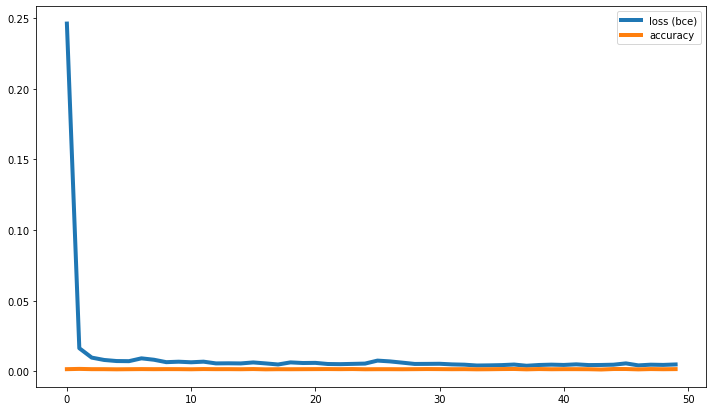

In [72]:
plt.figure(figsize=(12,7))

plt.plot(history.history["loss"], lw=4, label="loss (bce)")
plt.plot(history.history["accuracy"], lw=4, label="accuracy")

plt.legend()

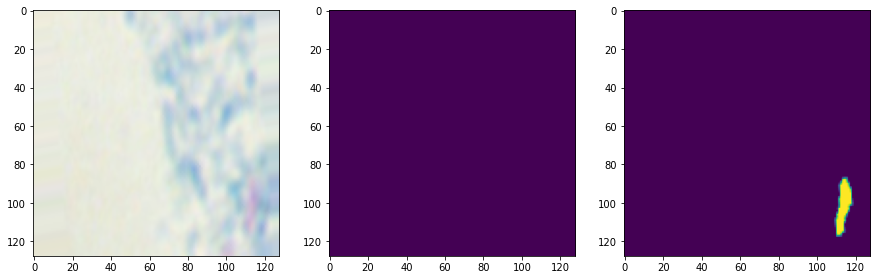

In [73]:
y_hat_mask = model.predict(np.reshape(img[0],(1,128,128,3)))
fig,axs = plt.subplots(1,3, figsize=(15,7))

axs[0].imshow(img[0])
axs[1].imshow(y_hat_mask.reshape(128,128))
axs[2].imshow(mask[0].reshape(128,128))